In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from idlmam import set_seed

import scipy
import scipy.ndimage

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, getMaskByFill

import os

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
import requests
from PIL import Image
from io import BytesIO

#This image was by 	Sajjad Fazel https://commons.wikimedia.org/wiki/User:SajjadF
url = "https://upload.wikimedia.org/wikipedia/commons/9/9c/Zebra_in_Mikumi.JPG"

response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [7]:
to_tensor = transforms.ToTensor() # transform converts PIL images to PyTorch tensors
resize = torchvision.transforms.Resize(1000) #Resize smallest dimension to 1000 pixels
crop = torchvision.transforms.CenterCrop((1000, 1000)) #crop out the cente 1000x1000 pixels
img_tensor_big = to_tensor(crop(resize(img))) #combine all three transformation steps to convert the image

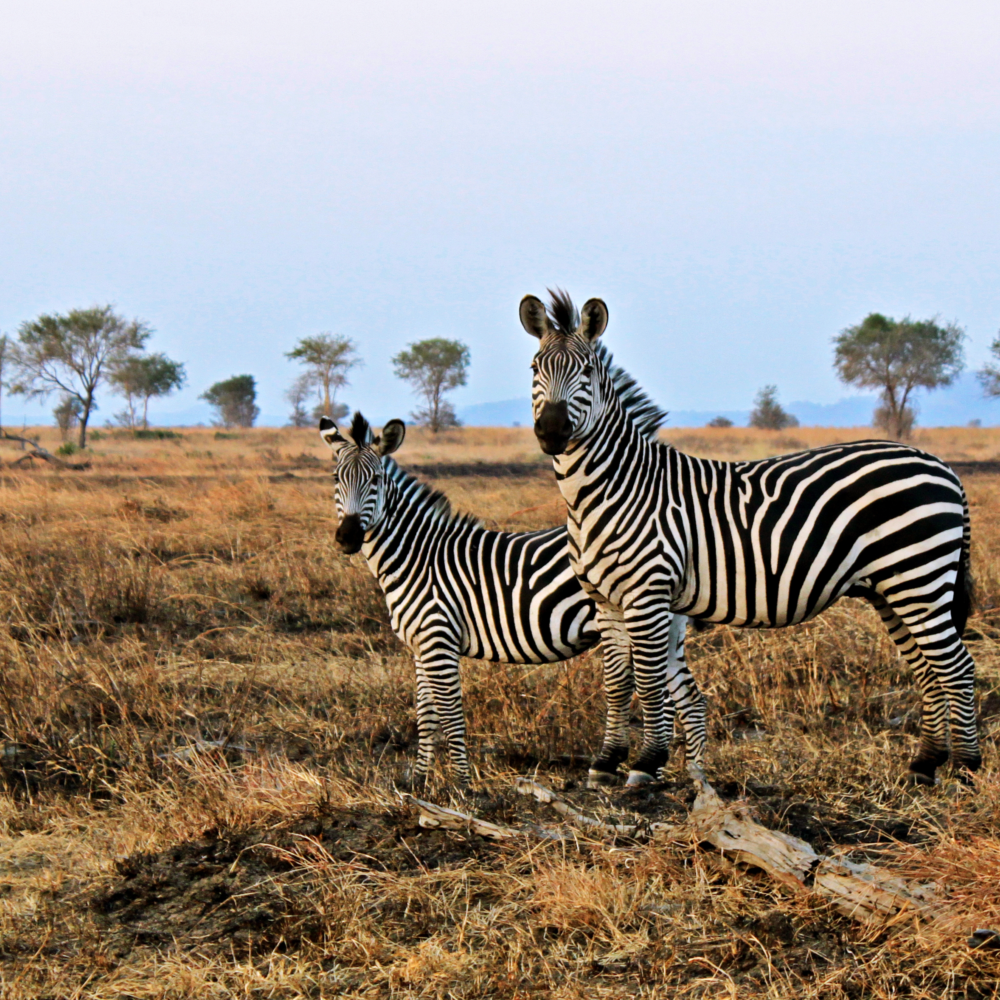

In [8]:
to_img = transforms.ToPILImage()
to_img(img_tensor_big)

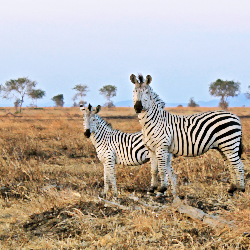

In [9]:
shrink_factor = 4 # How much pooling to perform
img_tensor_small = F.max_pool2d(img_tensor_big, (shrink_factor,shrink_factor)) #Apply pooling
to_img(img_tensor_small) #Look at the resulting image

In [10]:
B = 128
epochs = 30

train_transform = transforms.Compose( #our transform for training, random crop -> PyTorch tensor
    [
        transforms.RandomCrop((24,24)),
        transforms.ToTensor(),
    ])
test_transform = transforms.Compose( #our transform for testing, crop the center -> PyTorch tensor
    [
        transforms.CenterCrop((24,24)),
        transforms.ToTensor(),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=B, shuffle=True, num_workers=2)
#A version of the test set with full 32x32 images, so we can test specific crops
testset_nocrop = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
#Our test loader used during evaluation is the deterministic center crop. 
test_loader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #Mappnig of the class index back to their original names for CIFAR10

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


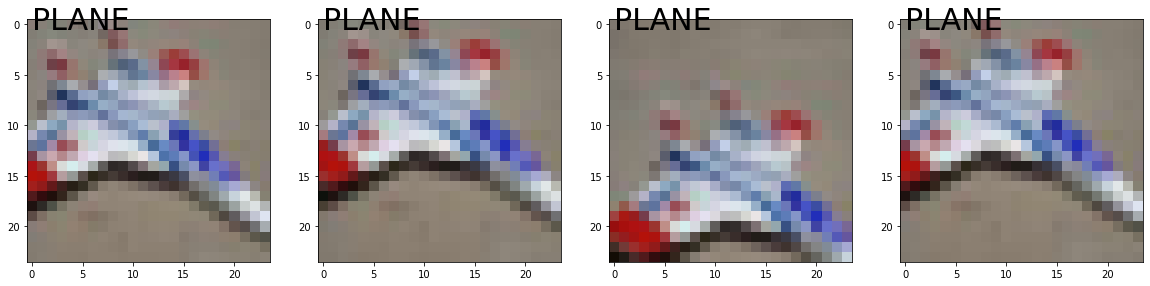

In [11]:
f, axarr = plt.subplots(1,4, figsize=(20,10)) #Make a 1x4 grid
for i in range(4): 
    x, y = trainset[30] #Grabing a specific item from the train set (I like planes)
    axarr[i].imshow(x.numpy().transpose(1,2,0)) #Re-order to (W, H, C) that numpy & matplotlib like for images
    axarr[i].text(0.0, 0.5, cifar10_classes[y].upper(), dict(size=30, color='black')) #Plot with class name in the corner

In [12]:
C = 3 #Number of input channels
h = 16 #Number of channels in the hidden layer
filter_size = 3
pooling_rounds = 2

def cnnLayer(in_size, out_size, filter_size): #helper function like we have done many times now
    return nn.Sequential(
        nn.Conv2d(in_size, out_size, filter_size, padding=filter_size//2),
        nn.BatchNorm2d(out_size),
        nn.ReLU())

normal_CNN = nn.Sequential( #a normal CNN with blocks of 2 cnn layers seperated by max-pooling
    cnnLayer(C, h, filter_size), 
    cnnLayer(h, h, filter_size),
    nn.MaxPool2d(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.MaxPool2d(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.Flatten(),
    nn.Linear(h*(24//(2**pooling_rounds))**2, len(cifar10_classes)) # $\text{# channels} \cdot \left(\frac{24 \text{pixels}}{2^{\text{rounds of pooling}}}\right)^2 = $ number of inputs to final layer
)

loss = nn.CrossEntropyLoss()
#Setting up our optimizer with a learning rate scheduler to maxmimize performance. 
optimizer = torch.optim.AdamW(normal_CNN.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
#Train our model like normal
normal_results = train_network(normal_CNN, loss, train_loader, epochs=epochs, device=device,  test_loader=test_loader, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

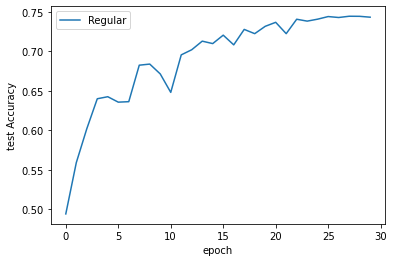

In [13]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')

In [15]:
test_img_id = 213 # test image to grab
x, y = testset_nocrop[test_img_id] # get the original 32x32 image
offset_predictions = [] #we are going to save the prediction for each 24x24 sub-image here
normal_CNN = normal_CNN.eval()
for i in range(8): # for up/down shifts
    for j in range(8): #for left/right shifts
        x_crop = x[:,i:i+24, j:j+24].to(device) #grab the cropped image
        with torch.no_grad(): 
            prob_y = F.softmax(normal_CNN(x_crop.unsqueeze(0)), dim=-1).cpu().numpy()[0,y] #classify the image, and get the probability of the correct class
            offset_predictions.append((x_crop, prob_y)) #save the resulting score

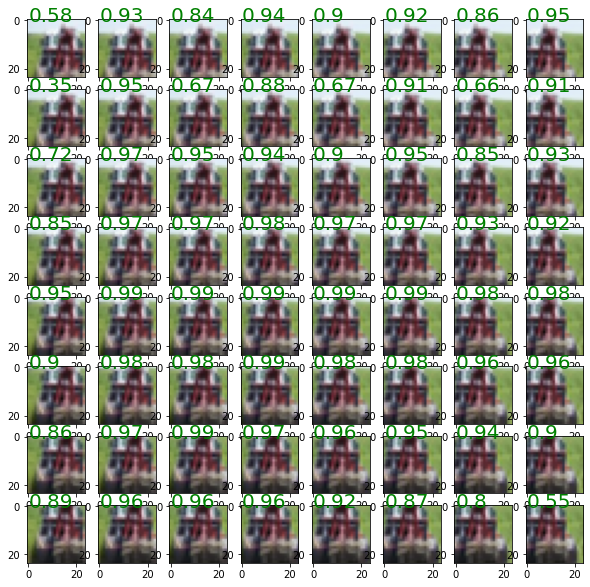

In [16]:
f, axarr = plt.subplots(8,8, figsize=(10,10)) # 8x8 grid of images
for i in range(8): #for each row
    pos = 0 #keep track of which specific shift we are accessing
    for x, score in offset_predictions[i*8:][:8]: #grab the next 8 images to fill out the columns
        axarr[i, pos].imshow(x.cpu().numpy().transpose(1,2,0)) #plot the 24x24 sub-image
        axarr[i, pos].text(0.0, 0.5, str(round(score,2)), dict(size=20, color='green'))#print the probability of the correct class in the top left. 
        pos += 1 #move to the next image position

In [18]:
class BlurLayer(nn.Module):
    def __init__(self, kernel_size=5, stride=2, D=2):
        """
        kernel_size: how wide should the blurring be
        stride: how much should the output shrink by
        D: how many dimensions in the input. D=1, D=2, or D=3 for tensors of shapes (B, C, W), (B, C, W, H), (B, C, W, H, Z) respectively.
        """
        super(BlurLayer, self).__init__()
        
        base_1d = scipy.stats.binom.pmf(list(range(kernel_size)), kernel_size, p=0.5)#make a 1d binomial distribution. This computes the normalized filter_i value for all k values.
        #z is a 1d filter
        if D <= 0 or D > 3:
            raise Exception() #invalid option for D!
        if D >= 1:
            z = base_1d #we are good
        if D >= 2:
            z = base_1d[:,None]*z[None,:] #the 2-d filter can be made by multiplying two 1-d filters
        if D >= 3:
            z = base_1d[:,None,None]*z #the 3-d filter can be made by multiplying the 2-d version with a 1-d version
        #Applying the filter is a convolution, so we will save the filter as a parameter in this layer. requires_grad=False because we don't want it to change
        self.weight = nn.Parameter(torch.tensor(z, dtype=torch.float32).unsqueeze(0), requires_grad=False)
        self.stride = stride

    def forward(self, x):
        C = x.size(1) #How many channels are here? 
        ks = self.weight.size(0)#How wide was our internal filter?

        #All three calls are the same, we just need to know which conv function should we call?
        #The groups argument is used to apply the single filter to every channel, since we don't have multipler filters like a normal convolutional layer.
        if len(self.weight.shape)-1 == 1:
            return F.conv1d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        elif len(self.weight.shape)-1 == 2:
            return F.conv2d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        elif len(self.weight.shape)-1 == 3:
            return F.conv3d(x, torch.stack([self.weight]*C), stride=self.stride, groups=C, padding=ks//self.stride)
        else:
            raise Exception() #We should never reach this code, lets us know we have a bug if it happens!


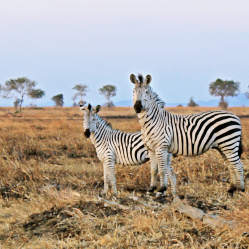

In [19]:
tmp = F.max_pool2d(img_tensor_big, (shrink_factor,shrink_factor), stride=1, padding=shrink_factor//2) #Apply max-pooling with a stride of 1
img_tensor_small_better = BlurLayer(kernel_size=int(1.5*shrink_factor), stride=shrink_factor)(tmp.unsqueeze(0)) #Blue the max-pooling result
to_img(img_tensor_small_better.squeeze()) #show the result

In [20]:
class MaxPool2dAA(nn.Module):
    def __init__(self, kernel_size=2, ratio=1.7):
        """
        kernel_size: how much to pool by
        ratio: how much larger the bluring filter should be than the pooling size
        """
        super(MaxPool2dAA, self).__init__()

        blur_ks = int(ratio*kernel_size) #make a slightly larger filter for bluring
        self.blur = BlurLayer(kernel_size=blur_ks, stride=kernel_size, D=2) #create the blur kernel
        self.kernel_size = kernel_size #and store the pooling size

    def forward(self, x):
        ks = self.kernel_size 
        tmp = F.max_pool2d(x, ks, stride=1, padding=ks//2) #Apply pooling with a stride=1
        return self.blur(tmp) #blue the result

In [21]:
aaPool_CNN = nn.Sequential( #same architecture as normal_CNN, but we replaced pooling with our anti-aliased version
    cnnLayer(C, h, filter_size), 
    cnnLayer(h, h, filter_size),
    MaxPool2dAA(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    MaxPool2dAA(2),
    cnnLayer(h, h, filter_size),
    cnnLayer(h, h, filter_size),
    nn.Flatten(),
    nn.Linear((24//(2**pooling_rounds))**2*h, len(cifar10_classes))
)

optimizer = torch.optim.AdamW(aaPool_CNN.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

aaPool_results = train_network(aaPool_CNN, loss, train_loader, epochs=epochs, device=device, test_loader=test_loader, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

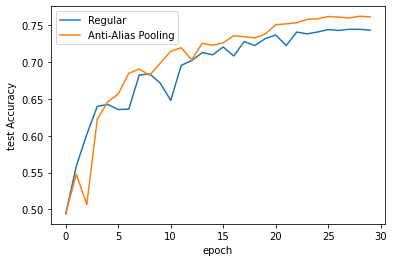

In [22]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=aaPool_results, label='Anti-Alias Pooling')

[Text(0.5, 0, 'Pixel shifts'),
 Text(0, 0.5, 'Predicted probability of correct class')]

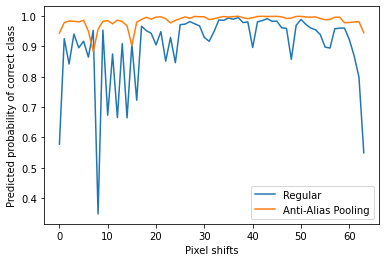

In [23]:
x, y = testset_nocrop[test_img_id] # get the original 32x32 image
offset_predictions_aa = [] #we are going to save the prediction for each 24x24 sub-image here
aaPool_CNN = aaPool_CNN.eval()
for i in range(8): # for up/down shifts
    for j in range(8): #for left/right shifts
        x_crop = x[:,i:i+24, j:j+24].to(device) #grab the cropped image
        with torch.no_grad(): 
            prob_y = F.softmax(aaPool_CNN(x_crop.unsqueeze(0)), dim=-1).cpu().numpy()[0,y] #classify the image, and get the probability of the correct class
            offset_predictions_aa.append((x_crop, prob_y)) #save the resulting score

sns.lineplot(x=list(range(8*8)), y=[val for img,val in offset_predictions], label='Regular')
ax = sns.lineplot(x=list(range(8*8)), y=[val for img,val in offset_predictions_aa], label='Anti-Alias Pooling')
ax.set(xlabel='Pixel shifts', ylabel='Predicted probability of correct class')

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, channels, kernel_size=3, stride=1, activation=nn.ReLU(), ReZero=True):
        """
        in_channels: how many channels come into this residual block
        channels: the number of output channels for this residual block
        kernel_size: the size of the filters to use in this residual block
        stride: the stride of the convolutions in this block. Larger strides will shrink the output. 
        activation: what activation function to use
        ReZero: whether or not ReZero style intitializations should be used. 
        """
        super().__init__()
        
        self.activation = activation
        #How much to padd by so that W/H stays the same
        pad = (kernel_size-1)//2
        filter_size = (kernel_size,kernel_size)
        
        #complex branch of the network that applies two rounds of layers
        self.F = nn.Sequential(
            nn.Conv2d(in_channels, channels, filter_size, padding=pad, bias=False),
            nn.BatchNorm2d(channels),
            activation,
            nn.Conv2d(channels, channels, filter_size, padding=pad, stride=stride, bias=False),
            nn.BatchNorm2d(channels),
        )
        
        #alpha is a float if we are not using ReZero, or a Parameter if we are!
        self.alpha = 1.0
        if ReZero:
            self.alpha = nn.Parameter(torch.tensor([0.0]), requires_grad=True) 
        
        #Shortcut is the identify function, which returns the input as the output
        self.shortcut = nn.Identity()
        #Unless the output of F will have a different shape due to a change in 
        #the number of channels or stride, then we will make the short cude a 
        #1x1 convolution as a "projection" to change it's shape. 
        if in_channels != channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, channels, 1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(channels),
            )
    
    def forward(self, x):
        #Compute the results of F(x) and x, as needed
        f_x = self.F(x)
        x = self.shortcut(x)
        
        if isinstance(self.alpha,nn.Parameter):#ReZero
            return x + self.alpha * self.activation(f_x)
        else:#Normal Residual Block
            return self.activation(x + f_x)
#Caption: Implementation of the ReZero style residual block with optional shortcut connections to shrink the size of a layer. The ReZero approach makes alpha a parameter to be learned, otherwise a normal style Residual Block is used. 

In [25]:
resnetReZero_cifar10 = nn.Sequential( #Train a new residual network using the ReZero approach 
    ResidualBlock(C, h, ReZero=True),
    *[ResidualBlock(h, h, ReZero=True) for _ in range(6)],
    ResidualBlock(h, 2*h, ReZero=True, stride=2), #Instead of pooling, lets do strided convolution layer. This keeps the skip connections intact without extra code
    *[ResidualBlock(2*h, 2*h, ReZero=True) for _ in range(6)],
    ResidualBlock(2*h, 4*h, ReZero=True, stride=2),
    *[ResidualBlock(4*h, 4*h, ReZero=True) for _ in range(6)],
    ResidualBlock(4*h, 4*h, ReZero=True, stride=2),
    *[ResidualBlock(4*h, 4*h, ReZero=True) for _ in range(6)],
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(4*h, len(cifar10_classes)), #We used adaptive pooling down to 1x1, so easier to compute the number of inputs to the final layer.
)

optimizer = torch.optim.AdamW(resnetReZero_cifar10.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
resnetReZero_results = train_network(resnetReZero_cifar10, loss, train_loader, epochs=epochs, device=device, test_loader=test_loader, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score})

In [26]:
resnet_cifar10 = nn.Sequential( #First lets train a normal Residual Network without any ReZero
    ResidualBlock(C, h, ReZero=False),
    *[ResidualBlock(h, h, ReZero=False) for _ in range(6)],
    ResidualBlock(h, 2*h, ReZero=False, stride=2),
    *[ResidualBlock(2*h, 2*h, ReZero=False) for _ in range(6)],
    ResidualBlock(2*h, 4*h, ReZero=False, stride=2),
    *[ResidualBlock(4*h, 4*h, ReZero=False) for _ in range(6)],
    ResidualBlock(4*h, 4*h, ReZero=False, stride=2),
    *[ResidualBlock(4*h, 4*h, ReZero=False) for _ in range(6)],
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(4*h, len(cifar10_classes)), #We used adaptive pooling down to 1x1, so easier to compute the number of inputs to the final layer.
)
optimizer = torch.optim.AdamW(resnet_cifar10.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
resnet_results = train_network(resnet_cifar10, loss, train_loader, epochs=epochs, device=device, test_loader=test_loader, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

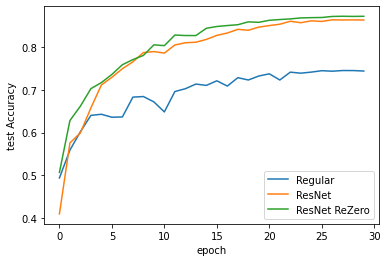

In [27]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=resnet_results, label='ResNet')
sns.lineplot(x='epoch', y='test Accuracy', data=resnetReZero_results, label='ResNet ReZero')

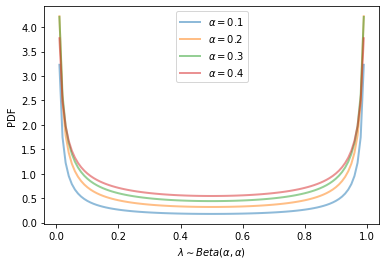

In [28]:
range_01 = np.arange(100)[1:]/100 #Lets take 100 steps along the x-axis for plotting
for alpha in [0.1, 0.2, 0.3, 0.4]: #Four different hyper-parameter values to demonstrate
    plt.plot(range_01, scipy.stats.beta(alpha, alpha).pdf(range_01), lw=2, ls='-', alpha=0.5, label=r'$\alpha='+str(alpha)+"$") #Plotting the Beta distribution for each option.
plt.xlabel(r"$\lambda \sim Beta(\alpha, \alpha)$")
plt.ylabel(r"PDF")
plt.legend()

In [29]:
class MixupLoss(nn.Module):
    def __init__(self, base_loss=nn.CrossEntropyLoss()):
        """
        base_loss: the original loss function to use as a sub-component of Mixup, or to use at test time to see how well we are doing. 
        """
        super(MixupLoss, self).__init__()
        self.loss = base_loss

    def forward(self, y_hat, y):
        if isinstance(y, tuple): #we should be doing mixup!
            if len(y) != 3:
                raise Exception() #There should be a tuple of y_i, y_j, and lambda!
            y_i, y_j, lambda_ = y #break the tuple out into its components
            return lambda_ * self.loss(y_hat, y_i) + (1 - lambda_) * self.loss(y_hat, y_j)
        #Else, y is just a normal tensor and normal set of labels! Compute it the normal way
        return self.loss(y_hat, y)

In [30]:
from torch.utils.data.dataloader import default_collate

class MixupCollator(object):
    def __init__(self, alpha=0.25, base_collate=default_collate):
        """
        alpha: how agressive the mixing of data is, recomended to be be in [0.1, 0.4], but could be in [0, 1]
        base_collate: how to take a list of datapoints and convert them into one larger batch. By default uses the same default as PyTorch's DataLoader class. 
        """
        self.alpha = alpha
        self.base_collate = base_collate
    def __call__(self, batch):
        #batch comes in as a list, convert it into an actual batch of data
        x, y = self.base_collate(batch)
        #sample the value of lambda to use. note the "_" at the end, because 
        #lambda is a key word in ptyhong
        lambda_ = np.random.beta(self.alpha, self.alpha)
        #create a random shuffled order pi
        B = x.size(0)
        shuffled_order = torch.randperm(B)

        #compute the mixed version of the input data
        x_tilde = lambda_ * x + (1 - lambda_) * x[shuffled_order, :]
        #get the labels
        y_i, y_j = y, y[shuffled_order]
        #return a tuple of two items. First is the input data, second is another
        #tuple of 3 items that MixupLoss needs
        return x_tilde, (y_i, y_j, lambda_)


In [31]:
#Replace the data loader with a new one that uses our MixupCollator
train_loader_mixup = torch.utils.data.DataLoader(trainset, batch_size=B, num_workers=2, shuffle=True, collate_fn=MixupCollator())

resnetReZero_cifar10.apply(weight_reset) #re-set the weights to out of lazyness
#the optimizer and schduler remain unchainged
optimizer = torch.optim.AdamW(resnetReZero_cifar10.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
#We will wrap our normal `loss` with our new `MixupLoss` since we are training with Mixup
resnetReZero_mixup_results = train_network(resnetReZero_cifar10, MixupLoss(loss), train_loader_mixup, epochs=epochs, device=device, test_loader=test_loader, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score})

/home/edraff/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/edraff/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

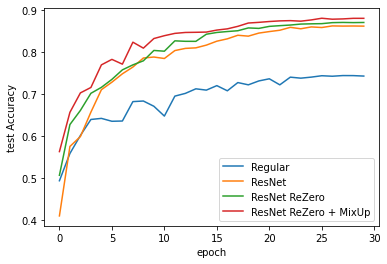

In [32]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=resnet_results, label='ResNet')
sns.lineplot(x='epoch', y='test Accuracy', data=resnetReZero_results, label='ResNet ReZero')
sns.lineplot(x='epoch', y='test Accuracy', data=resnetReZero_mixup_results, label='ResNet ReZero + MixUp')